In [17]:
import os
import numpy as np
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torchviz import make_dot
from tqdm import tqdm, tnrange
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
torch.manual_seed(99)


In [28]:
### Config
class CFG:
    seed = 99
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    batch_size = 32
    model_path = ".\model"

class CFG_XOR:
    XOR_data_path = ".\Xor_Dataset.csv"
    batch_size = 128
    input_size = 2
    output_size = 1
    input = ['X', 'Y']
    output = 'Z'
    epochs = 100
    lr = 0.01

class CFG_MNIST:
    MNIST_data_path = ".\MNIST_data"
    batch_size = 256
    input_size = 28*28
    output_size = 10
    input = ['pixel_{}'.format(i) for i in range(784)]
    output = ['class_{}'.format(i) for i in range(10)]
    epochs = 10
    lr_list = [0.00000001, 0.001, 1]

# BAI 1: XOR

In [3]:
XOR_df = pd.read_csv(CFG_XOR.XOR_data_path)# Kaggle XOR dataset
XOR_df.head(10)

,X,Y,Z
0,0,0,0
1,0,1,1
2,1,1,0
3,1,1,0
4,0,0,0
5,1,0,1
6,1,1,0
7,1,1,0
8,0,1,1
9,1,0,1


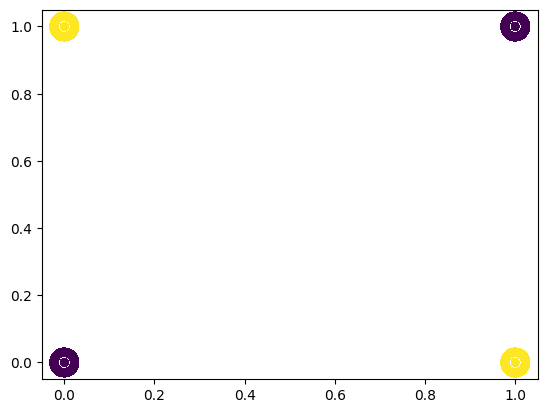

In [4]:
plt.scatter(XOR_df['X'], XOR_df['Y'], c=XOR_df['Z'], linewidths=15)

In [5]:
class XORDataModule():
    def __init__(self):
        self.data = pd.read_csv(CFG_XOR.XOR_data_path)
        self.batch_size = CFG_XOR.batch_size

    def train_test_split(self):
        X = self.data[['X', 'Y']].to_numpy()
        y = self.data['Z'].to_numpy().reshape(-1, 1)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, shuffle=True)
        return X_train, X_test, y_train, y_test

    def data_loader(self, train=True):
        if train:
            X_train, _, y_train, _ = self.train_test_split()
            return DataLoader(
                list(zip(torch.tensor(X_train), torch.tensor(y_train))),
                batch_size=self.batch_size, shuffle=True)
        else:
            _, X_test, _, y_test = self.train_test_split()
            return DataLoader(
                list(zip(torch.tensor(X_test), torch.tensor(y_test))),
                batch_size=self.batch_size, shuffle=False)


In [6]:
class XORNN(nn.Module):
    def __init__(self):
        super(XORNN, self).__init__()
        self.layer1 = nn.Linear(CFG_XOR.input_size, 3)
        self.layer2 = nn.Linear(3, CFG_XOR.output_size)
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.act(x)
        x = self.layer2(x)
        return x


In [7]:
xor_datamodule = XORDataModule()
xor_model = XORNN().to(CFG.device)

In [8]:
xor_train = xor_datamodule.data_loader()
xor_test = xor_datamodule.data_loader(train=False)
criterion = nn.MSELoss()
optimizer = optim.SGD(xor_model.parameters(), lr=CFG_XOR.lr)
epoch_loss_hist = []
batch_loss_hist = []

In [9]:
for epoch in range(CFG_XOR.epochs):
    for X, y in xor_train:
        optimizer.zero_grad()
        y_hat = xor_model(X.float())
        loss = criterion(y_hat, y.float())
        batch_loss_hist.append(loss.detach())
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch [{epoch + 1}/{CFG_XOR.epochs}], Loss: {loss.item():.4f}')
    epoch_loss_hist.append(loss.detach())

Epoch [1/100], Loss: 0.3060
Epoch [11/100], Loss: 0.2537
Epoch [21/100], Loss: 0.1905
Epoch [31/100], Loss: 0.0954
Epoch [41/100], Loss: 0.0238
Epoch [51/100], Loss: 0.0026
Epoch [61/100], Loss: 0.0002
Epoch [71/100], Loss: 0.0000
Epoch [81/100], Loss: 0.0000
Epoch [91/100], Loss: 0.0000


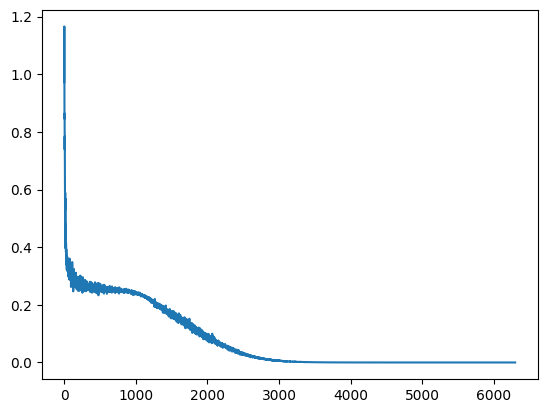

In [10]:
plt.plot(batch_loss_hist)

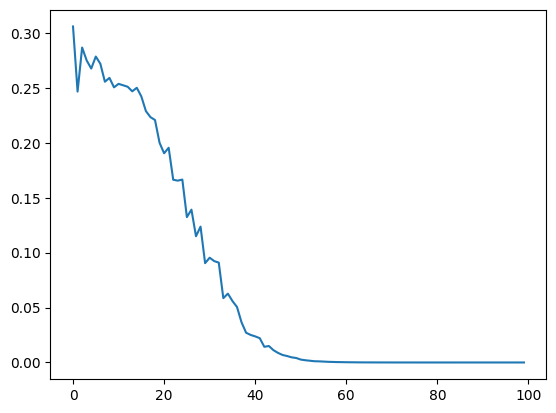

In [11]:
plt.plot(epoch_loss_hist)

# BAI 2

In [12]:
class MNISTDataModule():
    def __init__(self):
        self.batch_size = CFG.batch_size
        self.train = None
        self.val = None

    def data_loader(self):
        self.train = DataLoader(
            torchvision.datasets.MNIST(
                CFG_MNIST.MNIST_data_path,
                train=True, download=True,
                transform=torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize(
                        (0.1307,), (0.3081,))])),
                batch_size=self.batch_size, shuffle=True)
        
        self.val = DataLoader(
            torchvision.datasets.MNIST(
                CFG_MNIST.MNIST_data_path,
                train=False, download=True,
                transform=torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize(
                        (0.1307,), (0.3081,))])),
                batch_size=self.batch_size, shuffle=False)


In [13]:
class MNISTNN(nn.Module):
    def __init__(self):
        super(MNISTNN, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 20)
        self.layer2 = nn.Linear(20, 10)
        self.layer3 = nn.Linear(10, 10)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [14]:
mnist_datamodule = MNISTDataModule()
mnist_datamodule.data_loader()

In [15]:
(len(mnist_datamodule.val.dataset) /
(len(mnist_datamodule.train.dataset) + len(mnist_datamodule.val.dataset))) * 100
# close to 20%

14.285714285714285

Label: tensor(5)


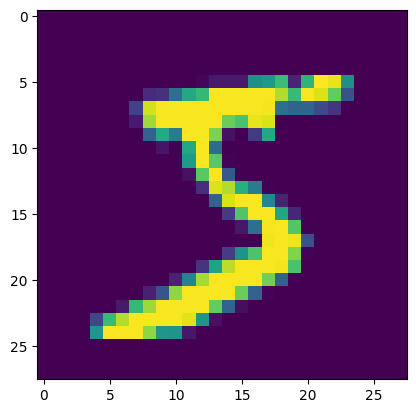

In [16]:
plt.imshow(mnist_datamodule.train.dataset[0][0].view(28, 28))
print("Label:", mnist_datamodule.train.dataset.targets[0])

In [26]:
def init(lr):
    mnist_model = MNISTNN()
    mnist_model.to(CFG.device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(mnist_model.parameters(), lr=lr)
    epoch_loss_hist = []
    batch_loss_hist = []
    return mnist_model, criterion, optimizer, epoch_loss_hist, batch_loss_hist


def evaluate_model(model):
    y_pred = []
    y_true = []
    with torch.no_grad():
        for X, y in mnist_datamodule.val:
            X = X.view(-1, 28*28)
            y_hat = model(X)
            _, predicted = torch.max(y_hat.data, 1)
            y_pred.extend(predicted.tolist())
            y_true.extend(y.tolist())

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * accuracy_score(y_true, y_pred)))
    print('F1 score of the network on the 10000 test images: %d %%' % (
        100 * f1_score(y_true, y_pred, average='macro')))
    print('Recall score of the network on the 10000 test images: %d %%' % (
        100 * recall_score(y_true, y_pred, average='macro')))


def viz_batch_loss(lr):
    plt.plot(batch_loss_hist, label=f'{lr}')
    plt.title('Batch Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.show()


def viz_epoch_loss(lr):
    plt.plot(epoch_loss_hist, marker='o', label=f'{lr}')
    plt.title('Epoch Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()


Learning rate: 1e-08
Epoch [1/10], Loss: 2.3219
Epoch [2/10], Loss: 2.3112
Epoch [3/10], Loss: 2.4006
Epoch [4/10], Loss: 2.3564
Epoch [5/10], Loss: 2.2898
Epoch [6/10], Loss: 2.2910
Epoch [7/10], Loss: 2.3044
Epoch [8/10], Loss: 2.3197
Epoch [9/10], Loss: 2.2872
Epoch [10/10], Loss: 2.2351
Accuracy of the network on the 10000 test images: 10 %
F1 score of the network on the 10000 test images: 4 %
Recall score of the network on the 10000 test images: 10 %


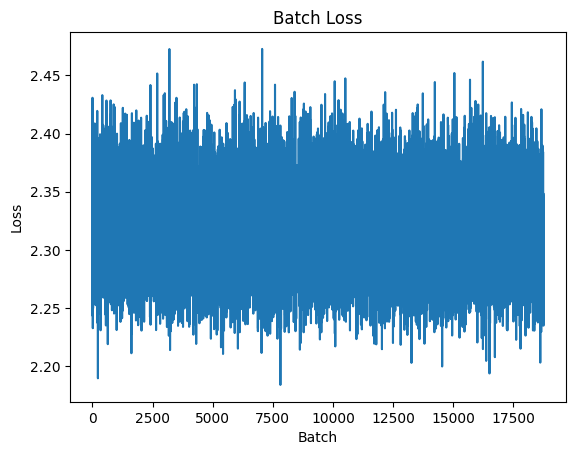

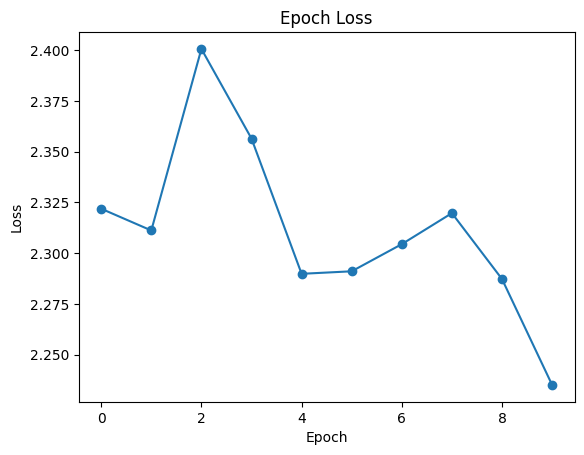

Learning rate: 0.001
Epoch [1/10], Loss: 0.2363
Epoch [2/10], Loss: 0.1596
Epoch [3/10], Loss: 0.2039
Epoch [4/10], Loss: 0.1771
Epoch [5/10], Loss: 0.0800
Epoch [6/10], Loss: 0.1057
Epoch [7/10], Loss: 0.2870
Epoch [8/10], Loss: 0.0216
Epoch [9/10], Loss: 0.0356
Epoch [10/10], Loss: 0.1407
Accuracy of the network on the 10000 test images: 95 %
F1 score of the network on the 10000 test images: 95 %
Recall score of the network on the 10000 test images: 95 %


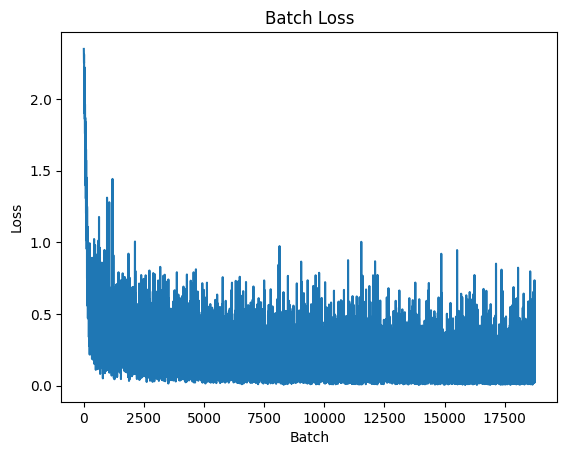

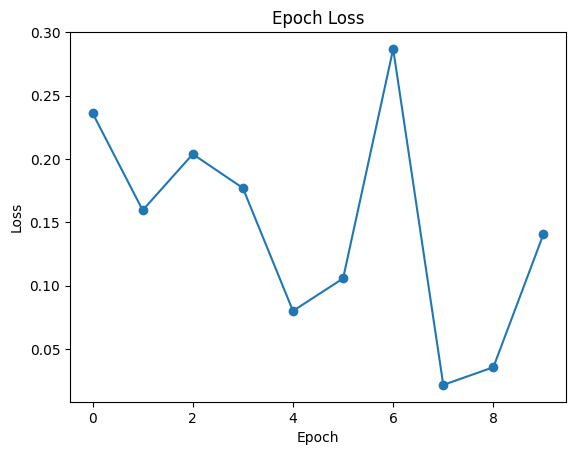

Learning rate: 1
Epoch [1/10], Loss: 2.4720
Epoch [2/10], Loss: 2.3168
Epoch [3/10], Loss: 2.3837
Epoch [4/10], Loss: 2.5466
Epoch [5/10], Loss: 2.3030
Epoch [6/10], Loss: 2.3123
Epoch [7/10], Loss: 2.3649
Epoch [8/10], Loss: 2.3816
Epoch [9/10], Loss: 2.5038
Epoch [10/10], Loss: 2.5465
Accuracy of the network on the 10000 test images: 8 %
F1 score of the network on the 10000 test images: 1 %
Recall score of the network on the 10000 test images: 10 %


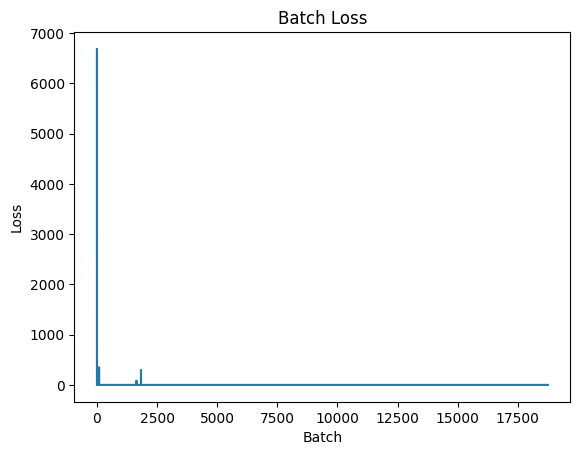

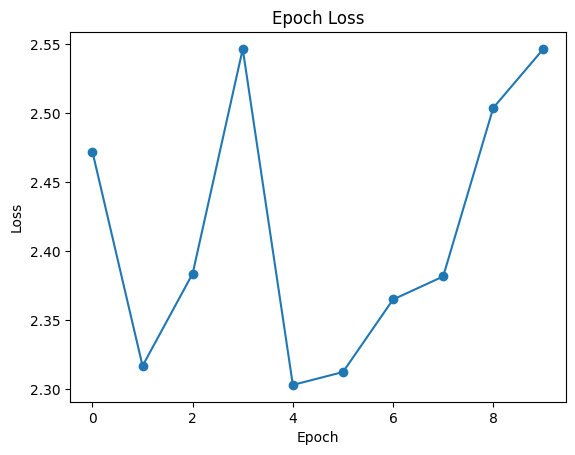

In [29]:
for lr in CFG_MNIST.lr_list:
    mnist_model, criterion, optimizer, epoch_loss_hist, batch_loss_hist = init(lr)
    print("Learning rate:", lr)
    for epoch in range(CFG_MNIST.epochs):
        for X, y in mnist_datamodule.train:
            optimizer.zero_grad()
            y_hat = mnist_model(X.view(-1, 28*28))
            loss = criterion(y_hat, y)
            batch_loss_hist.append(loss.detach())
            loss.backward()
            optimizer.step()

        if epoch % 1 == 0:
            print(f'Epoch [{epoch+1}/{CFG_MNIST.epochs}], Loss: {loss.detach():.4f}')
        epoch_loss_hist.append(loss.detach())
    evaluate_model(mnist_model)
    viz_batch_loss(lr)
    viz_epoch_loss(lr)


# BAI 3

Sử dụng hàm exponential (e) trong hàm softmax có một số lợi thế sau:

1. Hàm exponential là một hàm tăng trưởng nhanh, điều này giúp cho các giá trị trong vector đầu ra được phân bố rộng rãi hơn.
2. Hàm exponential là một hàm monotonic, điều này có nghĩa là nó luôn luôn tăng. Điều này đảm bảo rằng các giá trị trong vector đầu ra luôn là các số dương.
3. Hàm exponential là một hàm khác biệt được phân phối chuẩn, điều này có thể được sử dụng để cải thiện hiệu quả của quá trình học máy.

Nếu sử dụng số khác như 2, 3 hoặc 4 thay cho hàm exponential, thì các giá trị trong vector đầu ra sẽ không được phân bố rộng rãi như vậy. Điều này có thể dẫn đến việc mạng nơ-ron khó học được các phân phối xác suất phức tạp.